# Képfeldolgozás

Tartalom:

* Library-k
* Face detection
* MNIST példa
* Emotion detection

## Library-k (Python)

### OpenCV

Az egyik legrelevánsabb könyvtár. Régóta fejlesztik a klasszikus és modernebb algoritmusok egyaránt elérhetőek benne. A core C++-ban van írva és számos nyelvhez van interfésze, többek közt a Pythonhoz is (de van C#-ra is).

Python install link: https://pypi.org/project/opencv-python/  
Tutorial link: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html

### imutils

OpenCV-ben néhány egyszerűnek tűnő dolgot nehéz megcsinálni, például képforgatást. Ez lényegében egy wrapper az OpenCV fölött, hogy kényelmesebb legyen a használata. Néhány kiegészítő feature-t is tartalmaz, mint például a webkamera kezelése.

Link: https://github.com/jrosebr1/imutils

### scikit-image

Hasonló az OpenCV-hez, de nem annyira átfogó, viszont kényelmesebb a használata.

Link: https://scikit-image.org/


## Adat betöltés

In [1]:
from zipfile import ZipFile 
  
# specifying the zip file name 
files = ["samples.zip", "models.zip"]
  
# opening the zip file in READ mode 
for file_name in files:
  with ZipFile(file_name, 'r') as zip: 
      # extracting all the files 
      print('Extracting all the files now in {}'.format(file_name)) 
      zip.extractall()
      print('Done!')

Extracting all the files now in samples.zip
Done!
Extracting all the files now in models.zip
Done!


## Arc detekció

Ebben a részben megnézünk egy OpenCV-s megoldást képen történő arc detektálásra. A bemenet a webkamera képe lesz.


In [1]:
#from google.colab.patches import cv2_imshow  # to show the image at the end
import numpy as np
import argparse
import imutils
import time
import cv2

In [2]:
proto = "models/deploy.prototxt.txt"
model_name = "models/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNetFromCaffe(proto, model_name)

In [4]:
# grab the frame from the threaded video stream and resize it
# to have a maximum width of 400 pixels
frame = cv2.imread("samples/face-mask-coronavirus.png")  # let us see how well it generalizes
frame = imutils.resize(frame, width=400)
 
# grab the frame dimensions and convert it to a blob
(h, w) = frame.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0,
(300, 300), (104.0, 177.0, 123.0))
 
# pass the blob through the network and obtain the detections and
# predictions
net.setInput(blob)
detections = net.forward()
# loop over the detections
for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with the
    # prediction
    confidence = detections[0, 0, i, 2]
 
    # filter out weak detections by ensuring the `confidence` is
    # greater than the minimum confidence
    if confidence < 0.4:
        continue
 
    # compute the (x, y)-coordinates of the bounding box for the
    # object
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
 
    # draw the bounding box of the face along with the associated
    # probability
    text = "{:.2f}%".format(confidence * 100)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 0, 255), 2)
    cv2.putText(frame, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    # show the output frame
cv2.imshow("Corona", frame)
cv2.waitKey(0)

-1

## MNIST példa PyTorch alapon

Ebben a részben letöltjük és előkészítjük az MNIST adathalmazt. Az MNIST egy publikusan elérhető adathalmaz, ami kézzel írott számokat tartalmaz (0-9). A számok egy 28x28-as méretű szürkeskálájú képen (1 csatornás) vannak ábrázolva. Minden képhez elérhetők a labelek (a valós ábrázolt szám) is.

Leírás: http://yann.lecun.com/exdb/mnist/

In [5]:
from matplotlib import pyplot as plt  # vizualizációs library
from copy import deepcopy
import requests as rq  # url címről letöltéshez
import numpy as np  # mátrix library
import shutil  # magas szintű fájl és mappa kezelés (törlés, másolás stb.)
import gzip  # tömörített mappa kicsomagolása
import os

In [6]:
# adat letöltése és bináris fájlba írása
def download(link, saving_path):
    downloaded = rq.get(link, allow_redirects=True)  # engedjük, hogy az adott url átirányíthasson, ha akar
    with open(saving_path, 'wb') as f:
        f.write(downloaded.content)

In [7]:
# kicsomagoljuk a letöltött fájlokat
def unzip(file_name):
    new_file_name = file_name.replace('.gz', '.mnist')
    with gzip.open(file_name, 'rb') as src:
        with open(new_file_name, 'wb') as dst:
            shutil.copyfileobj(src, dst)
    return new_file_name

In [8]:
# a bináris fájlok felépítése specifikált
# az egyes emzők mérete vagy 8 bit vagy 32 bit
# a byte sorrend is specifikált
def read_int32(bin_file):
    int32 = np.dtype(np.int32).newbyteorder('>')
    return np.frombuffer(bin_file.read(4), dtype=int32)[0]

def read_uint8(bin_file):
    uint8 = np.dtype(np.uint8).newbyteorder('>')
    return np.frombuffer(bin_file.read(1), dtype=uint8)[0]

In [9]:
# beolvassuk a képeket, amik a kézzel írt számokat tartalmazzák
def read_img(file_name):
    
    images = []

    with open(file_name, 'rb') as imgs:

        # beolvassuk magic number, number of images, rows and cols of an image
        # http://yann.lecun.com/exdb/mnist/ (FILE FORMATUM AZ MNISTHEZ)
        mgb = read_int32(imgs)
        num_of_imgs = read_int32(imgs)
        rows = read_int32(imgs)  # sorok szama
        cols = read_int32(imgs)
        print(mgb, num_of_imgs, rows, cols)

        for i in range(num_of_imgs):
            
            # beolvassuk az egye pixeleket
            IMG = np.zeros(rows*cols, dtype=np.uint8)

            for px in range(rows*cols):
                IMG[px] = read_uint8(imgs)
            # a kép ki van lapítva egy képet formálunk belöle
            IMG = IMG.reshape((rows, cols))
            images.append(IMG)

            if (i + 1) % (num_of_imgs/20) == 0:
                print("Reading images: [%d%%]\r" %int((i+1)/num_of_imgs * 100), end="")
    print("Finished reading images")

    return mgb, num_of_imgs, images 

In [10]:
# beolvassuk cimkéket
def read_label(file_name):
    
    # read the file parts
    labels = []

    with open(file_name, 'rb') as lbs:

        # read magic number, number of images
        mgb = read_int32(lbs)
        num_of_imgs = read_int32(lbs)
        print(mgb, num_of_imgs)

        for i in range(num_of_imgs):

            LABEL = read_uint8(lbs)
            labels.append(LABEL)

            if (i + 1) % (num_of_imgs/20) == 0:
                print("Reading labels: [%d%%]\r" %int((i+1)/num_of_imgs * 100), end="")
    print("Finished reading labels")

    return mgb, num_of_imgs, labels

In [11]:
# OOP design
# így kényelmesebb lesz kezelni az adathalmazt
class MNISTdata:

    def __init__(self, x_train_s, y_train_s, x_test_s, y_test_s, num_train_imgs, num_test_imgs):
        self.X_train = x_train_s
        self.Y_train = y_train_s
        self.X_test = x_test_s
        self.Y_test = y_test_s
        self.num_train_imgs = num_train_imgs
        self.num_test_imgs = num_test_imgs

In [12]:
# beolvasó fv.
def load_mnist(folder):
    
    # url addresses for mnist
    url_train_image = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"
    url_train_label = "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"
    url_test_image = "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz"
    url_test_label = "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"

    # download packages if it was not downloaded
    train_imgs_file_name = folder + "/training_mnist_imgs.gz"
    train_lbls_file_name = folder + "/training_mnist_lbls.gz"
    test_imgs_file_name = folder + "/test_mnist_imgs.gz"
    test_lbls_file_name = folder + "/test_mnist_lbls.gz"

    # checking if a file exists
    train_I = os.path.exists(train_imgs_file_name)
    train_L = os.path.exists(train_lbls_file_name)
    test_I = os.path.exists(test_imgs_file_name)
    test_L = os.path.exists(test_lbls_file_name)
    
    if not test_L:
        download(url_test_label, test_lbls_file_name)
        unzip(test_lbls_file_name)
        print("test_L downloaded.")

    if not train_I:
        download(url_train_image, train_imgs_file_name)
        unzip(train_imgs_file_name)
        print("train_I downloaded.")
    
    if not train_L:
        download(url_train_label, train_lbls_file_name)
        unzip(train_lbls_file_name)
        print("train_L downloaded.")
    
    if not test_I:
        download(url_test_image, test_imgs_file_name)
        unzip(test_imgs_file_name)
        print("test_I downloaded.")
    

    # load in the images and labels
    train_imgs_file_name = folder + "/training_mnist_imgs.mnist"
    train_lbls_file_name = folder + "/training_mnist_lbls.mnist"
    test_imgs_file_name = folder + "/test_mnist_imgs.mnist"
    test_lbls_file_name = folder + "/test_mnist_lbls.mnist"

    # training images
    mgb, num_train_imgs, x_train_s = read_img(train_imgs_file_name)
    assert mgb == 2051, "Wrong magic number when training images were loaded!"

    # training labels (number of labels are the same as number of images)
    mgb, _, y_train_s = read_label(train_lbls_file_name)
    assert mgb == 2049, "Wrong magic number when training labels were loaded!"

    # test images 
    mgb, num_test_imgs, x_test_s = read_img(test_imgs_file_name)
    assert mgb == 2051, "Wrong magic number when test images were loaded!"

    # test labels
    mgb, _, y_test_s = read_label(test_lbls_file_name)
    assert mgb == 2049, "Wrong magic number when test labels were loaded!"
    
    data = MNISTdata(x_train_s, y_train_s, x_test_s, y_test_s, num_train_imgs, num_test_imgs)
    return data

In [13]:
# --------- ADATOK LETÖLTÉSE ---------
if not os.path.exists('mnist'):
  os.mkdir('mnist')

mnist_data = load_mnist('mnist')

test_L downloaded.
train_I downloaded.
train_L downloaded.
test_I downloaded.
2051 60000 28 28
Finished reading images
2049 60000
Finished reading labels
2051 10000 28 28
Finished reading images
2049 10000
Finished reading labels


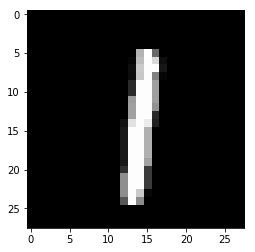

Hozzátartozó cimke: 1


In [17]:
# nézzük meg néhány elemét a letöltött adathalmaznak
def show_handwritten_digit(img_mtx):
    plt.imshow(img_mtx, cmap='gray')
    plt.show()

glance_idx = 40
show_handwritten_digit(mnist_data.X_train[glance_idx])
print("Hozzátartozó cimke: {}".format(mnist_data.Y_train[glance_idx]))

### Készítsük el a konvolúciós modellt

Építünk Pytorch-ban egy kis konvolúciós hálót.

In [18]:
import torch.nn as nn
import torch

In [19]:
class MNISTclassifier(nn.Module):
    def __init__(self):
        super(MNISTclassifier, self).__init__()
        # creating the network architecture

        # expected input size: (batch, 1, 28, 28)
        self.conv1_1 = nn.Conv2d(1, 8, (3, 3), stride=1)     # (., 8, 26, 26)
        self.conv1_2 = nn.Conv2d(8, 16, (3, 3), stride=1)    # (., 16, 24, 24)
        self.conv1_3 = nn.Conv2d(16, 16, (2, 2), stride=2)    # (., 16, 12, 12)
        self.conv1_4 = nn.Conv2d(16, 8, (3, 3), stride=1)   # (., 8, 10, 10)
        
        self.linear = nn.Linear(800, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        temp = self.relu(self.conv1_1(x))
        temp = self.relu(self.conv1_2(temp))
        temp = self.relu(self.conv1_3(temp))
        temp = self.relu(self.conv1_4(temp))
        temp = temp.view(-1, 800)

        temp = self.linear(temp)
        return temp

In [20]:
# példányosítsunk is egyet
device = torch.device("cuda")  # "cpu"
model = MNISTclassifier()
model.to(device)

MNISTclassifier(
  (conv1_1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv1_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv1_3): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv1_4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (linear): Linear(in_features=800, out_features=10, bias=True)
  (relu): ReLU()
)

### Elkészítjük az adatbetöltést

Az alábbiakra fogunk figyelni az adatbetöltés során:

* legyen tanításhoz és validációhoz is adat
* augmentációt is fogunk használni a batchek mintavételezése közben

In [21]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [22]:
# defining paramters
batch_size = 32
split_ratio = 0.8

In [23]:
# ez a Dataset, amit a Pytorch saját Loader-e vár
class MnistDataset(Dataset):
    def __init__(self, device, images, labels, transform=lambda x: np.expand_dims(x, axis=0)):  # a transformer olyan képet ad, aminek már van channelje
        self.device = device
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_ = self.images[index]
        image = self.transform(image_)  # itt alkalmazzuk az augmentciót
        label = self.labels[index]
        sample = {
            'image_id': index,
            'image': torch.tensor(image, dtype=torch.float, device=self.device),
            'target': torch.tensor(label, dtype=torch.long, device=self.device)
        }
        return sample

# defining the data loaders

# Splitting up the data
indices = list(range(mnist_data.num_train_imgs))
np.random.shuffle(indices)

split_index = int(len(indices) * split_ratio)
idices_for_train = indices[0:split_index]
indices_for_validation = indices[split_index:]

# Training loader
training_img = [mnist_data.X_train[idx] for idx in idices_for_train]  # list of images
training_label = [mnist_data.Y_train[idx] for idx in idices_for_train]

augmenter = transforms.Compose(  # tipikus augmentáció tartalmazza: forgatás, nyújtás, vágás, traszláció, zaj, kontraszt, fényesség stb.
    [   transforms.ToPILImage(),
        transforms.RandomAffine([-90, 90]),  # forgatás
        transforms.ToTensor()
    ]
)
dataset = MnistDataset(device, training_img, training_label, augmenter)
loader_train = DataLoader(dataset, batch_size)

# Validation loader
validation_img = [mnist_data.X_train[idx] for idx in indices_for_validation]  # képek listája
validation_label = [mnist_data.Y_train[idx] for idx in indices_for_validation]

dataset = MnistDataset(device, validation_img, validation_label)
loader_validation = DataLoader(dataset, batch_size)

# Test loader
test_img = mnist_data.X_test  # képek listája
test_label = mnist_data.Y_test

dataset = MnistDataset(device, test_img, test_label)
loader_test = DataLoader(dataset, 1)  # egyenként fogjuk tesztelni

### Implementáljuk a tanítást

In [24]:
import torch.optim as optim
from datetime import datetime

epochs = 6
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [25]:
print("Started training at {}".format(datetime.now()))

global_counter = 0

def _validation(epoch, index, global_counter):
    counter = 0
    loss_sum = 0.0
    for sample in loader_validation:
        counter += 1
        image = sample['image']
        target = sample['target']
        predicted = model(image)
        loss = criterion(predicted, target)
        loss_sum += loss.cpu().detach().numpy()  # a kiszámolt loss is a gpu-n van, vissza kell hozni
        del loss

    loss_mean = loss_sum / counter
    print("Current status at: (epoch: %d, i: %d ) with validation loss: %f"%(epoch, index, loss_mean))

for epoch in range(epochs):
    for index, sample in enumerate(loader_train):
        global_counter += 1

        image = sample['image']
        target = sample['target']

        predicted = model(image)
        loss = criterion(predicted, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss = loss.cpu().detach().numpy()

    _validation(epoch, index, global_counter)
    print("\r Current epoch {} and global counter {}".format(epoch, global_counter), end="")
print("Training has finished.")

Started training at 2020-03-26 17:48:34.879599


c:\users\adambudai\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Current status at: (epoch: 0, i: 1499 ) with validation loss: 57.700770
 Current epoch 0 and global counter 1500Current status at: (epoch: 1, i: 1499 ) with validation loss: 41.616882
 Current epoch 1 and global counter 3000Current status at: (epoch: 2, i: 1499 ) with validation loss: 40.697292
 Current epoch 2 and global counter 4500Current status at: (epoch: 3, i: 1499 ) with validation loss: 34.530025
 Current epoch 3 and global counter 6000Current status at: (epoch: 4, i: 1499 ) with validation loss: 38.067510
 Current epoch 4 and global counter 7500Current status at: (epoch: 5, i: 1499 ) with validation loss: 31.732196
 Current epoch 5 and global counter 9000Training has finished.


### Teszteljük a tanítás eredményét

In [26]:
# megszámoljuk hány esetben ad jó eredményt a megoldás
counter = 0
correctly_labeled = 0
for sample in loader_test:
    counter += 1
    image = sample['image']
    target = sample['target']
    predicted = torch.argmax(model(image))

    if predicted == target:
        if (counter%500 == 0):
          print(predicted.cpu().detach().numpy(), target[0].cpu().detach().numpy())
        correctly_labeled += 1

print("Correctly labeled {} out of {}".format(correctly_labeled, counter))

6 6
9 9
8 8
5 5
4 4
0 0
8 8
9 9
6 6
0 0
1 1
7 7
2 2
4 4
9 9
6 6
0 0
1 1
6 6
Correctly labeled 9448 out of 10000


### Feladatok:

1. Próbáld ki más paraméterekkel a hálót (learning rate, optimizer, epoch szám stb.)
2. Az augmentációban próbálj ki még több transformációt.
3. Hogyan tennéd bele a bemeneti kép normalizációját a Pytorch függvényei segítségével?
4. Hogy lehet regularizációt használni?

## Érzelem felismerés
Ebben a részben egy Keras implementációt próbálunk ki az arc érzelmeinek felismerésére.

In [12]:
from keras.preprocessing.image import img_to_array, image
from keras.models import load_model
import tensorflow as tf
import numpy as np
import imutils
import time
import cv2

Using TensorFlow backend.


In [ ]:
# parameters for loading data and images
detection_model_path = 'models/haarcascade_frontalface_default.xml'
emotion_model_path = 'models/_mini_XCEPTION.102-0.66.hdf5'

In [ ]:
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised", "neutral"]

In [ ]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

def load_image(image_path, grayscale=False, target_size=None):
    pil_image = image.load_img(image_path, grayscale, target_size=target_size)
    return image.img_to_array(pil_image)

def draw_bounding_box(face_coordinates, image_array, color):
    x, y, w, h = face_coordinates
    cv2.rectangle(image_array, (x, y), (x + w, y + h), color, 2)

def apply_offsets(face_coordinates, offsets):
    x, y, width, height = face_coordinates
    x_off, y_off = offsets
    return (x - x_off, x + width + x_off, y - y_off, y + height + y_off)

def draw_text(coordinates, image_array, text, color, x_offset=0, y_offset=0,
                                                font_scale=2, thickness=2):
    x, y = coordinates[:2]
    cv2.putText(image_array, text, (x + x_offset, y + y_offset),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale, color, thickness, cv2.LINE_AA)

def detect_faces(detection_model, gray_image_array):
    return detection_model.detectMultiScale(gray_image_array, 1.3, 5)

def get_labels():
    return {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}

def recognize_emotion(img_path):
    emotion_labels = get_labels()
    
    rgb_image = load_image(img_path, grayscale=False)
    gray_image = load_image(img_path, grayscale=True)
    gray_image = np.squeeze(gray_image)
    gray_image = gray_image.astype('uint8')
    
    faces = detect_faces(face_detection, gray_image)
    emotion_target_size = emotion_classifier.input_shape[1:3]
    
    for face_coordinates in faces:

        x1, x2, y1, y2 = apply_offsets(face_coordinates, (0, 0))
        gray_face = gray_image[y1:y2, x1:x2]

        try:
            gray_face = cv2.resize(gray_face, (emotion_target_size))
        except:
            continue

        gray_face = preprocess_input(gray_face, True)
        gray_face = np.expand_dims(gray_face, 0)
        gray_face = np.expand_dims(gray_face, -1)
        emotion_label_arg = np.argmax(emotion_classifier.predict(gray_face))
        emotion_text = emotion_labels[emotion_label_arg]
        color = (255, 0, 0)
        draw_bounding_box(face_coordinates, rgb_image, color)
        draw_text(face_coordinates, rgb_image, emotion_text, color, 0, -50, 1, 2)

    return cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)

In [16]:
detected = recognize_emotion('samples/surprised.jpg')
cv2.imwrite('samples/predicted_test_image.png', detected)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


True